In [1]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
import os, sys
sys.path.append(os.path.join("../.."))

import privugger.transformer.datastructures as pvds
from privugger.transformer import *

ModuleNotFoundError: No module named 'privugger'

# Getting started with Privugger

This is a tutorial on how to use the Privugger library. Privugger is based on the privug method introduced in [this paper](https://arxiv.org/abs/2011.08742). In a nutshell, the analysis is split in 5 steps.

## Program to analyze

We first define the program we are interested in analyzing. In this example, we consider a program computing the average of a list of ages. At first sight, releasing publicly the output of the program should no pose any privacy; lets verify this whether this is the case with privugger.

In [25]:
def avg(ages):
    return (ages.sum()) / (ages.size)

## Input specification (attacker knowledge about the input)

In [26]:
# input spec
ages = Normal(mu=10,std=2,num_elements=10)

# wrap everything into a dataset
ds = pvds.Dataset(input_specs=[ages],var_names=['ages'])

## Inference

In [27]:
trace = infer(data_spec=ds,
              program_output=Float,
              program=avg,
              draws=10000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


import theano
import theano.tensor as tt
import numpy as np


def method(ages):

    @theano.compile.ops.as_op(itypes=[tt.dvector], otypes=[tt.dscalar])
    def avg(ages):
        return np.array(ages.sum() / ages.size)
    return avg(ages)

[ages ~ Normal]


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [ages]


Sampling 2 chains for 1_000 tune and 10_000 draw iterations (2_000 + 20_000 draws total) took 6 seconds.


## Posterior Analysis

### Distribution visualization

As a first example of analysis, we use the `arviz` library to visualize the distribution of the output of the `avg` program.

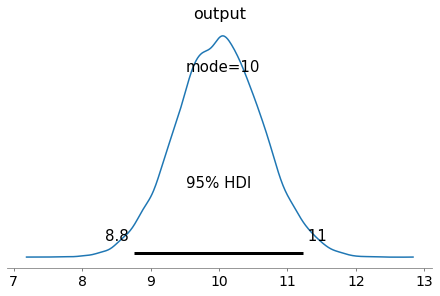

In [51]:
pm.plot_posterior(trace, var_names=['output'], hdi_prob=.95, point_estimate='mode'); # plot the inferred distribution of the output

This plot indicates that, given our prior, the output of the program `avg` can be between 8.8 and 11 with 10 being the most likely output.

We can also visualize the distribution of each of the elements in the dataset (recall the dataset consisted in a list of 10 elements modeling the age of different individuals)

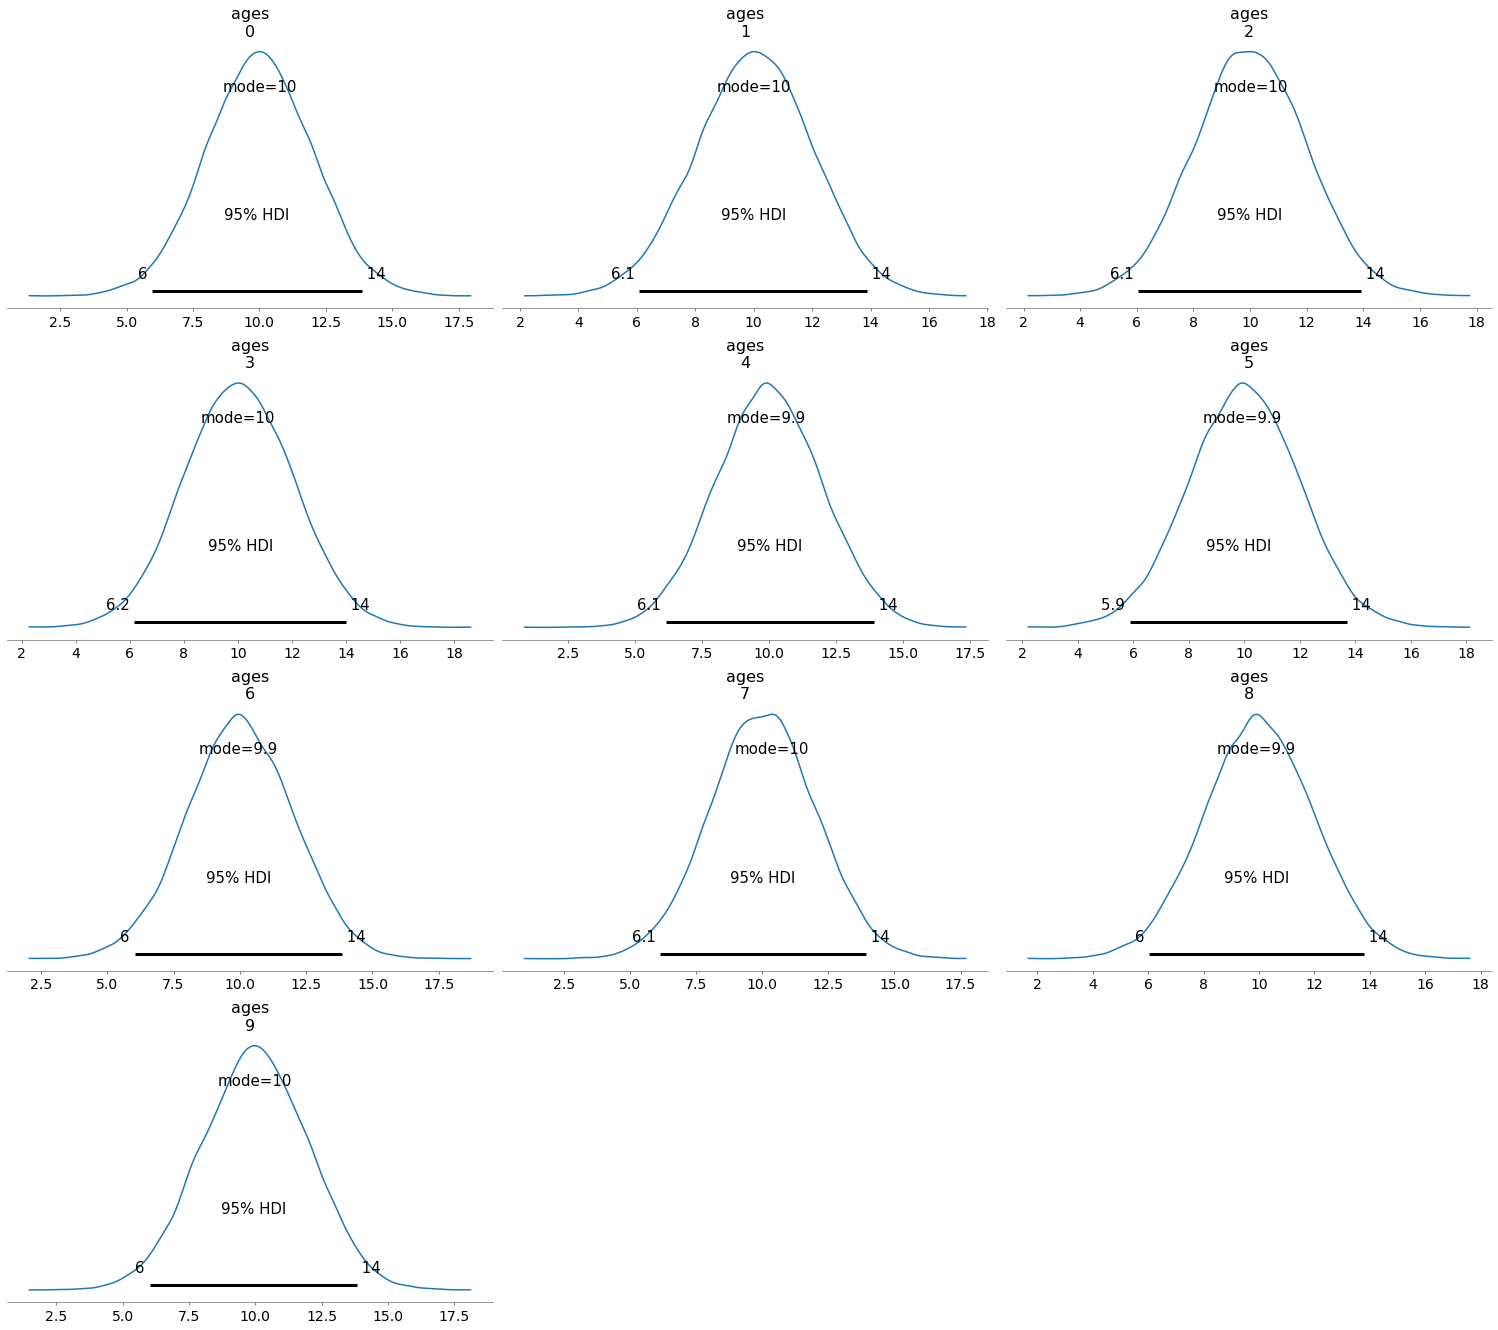

In [53]:
pm.plot_posterior(trace, var_names=['ages'], hdi_prob=.95, point_estimate='mode'); # plot the inferred distribution of the output

In [40]:
trace['ages'][:,0].shape

(20000,)

# Old program

## Define the method
IMPORTANT! Remember to add type annotation to your method using the tool `typing`

In [49]:
def privacy_protection_mechanism(a: int) -> int:
    secret = 1024
    res = a == 1024
    return res

Since the program currently loads from a file, you can either manually place the function in the file `program_to_be_analysed.py` or use the code below

In [50]:
import inspect
with open("program_to_be_analysed.py", "w") as f:
    f.write("from typing import * \n \n \n")
    f.write(inspect.getsource(privacy_protection_mechanism))

## Lift the program to a probability monad
By the use of the transformer plugin the program will be analysed and converted to a method that works on probability distributions

After this step a function called `method(...)` exist

In [51]:
lifted_program = load("program_to_be_analysed.py", "privacy_protection_mechanism")
exec(astor.to_source(lifted_program))

import theano
import theano.tensor as tt
import numpy as np
from functools import reduce
from typing import List, Tuple


def method(a: int) ->int:

    @theano.compile.ops.as_op(itypes=[tt.lscalar], otypes=[tt.lscalar])
    def privacy_protection_mechanism(a: int) ->int:
        secret = 1024
        res = a == 1024
        return np.int64(res)
    return privacy_protection_mechanism(a)



## Simulate attackers on the method
This step is done to find the most vulnerable attackers

In [54]:
results = simulate(method, max_examples=20, num_samples=1000, ranges=[(1000, 1050)])

/Users/maoj/opt/anaconda3/envs/dev/lib/python3.7/site-packages/pymc3/sampling.py:468: FutureWarning: In an upcoming release, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  FutureWarning,
Only 100 samples in chain.
Sequential sampling (2 chains in 1 job)
Metropolis: [intDist_0]


Sampling 2 chains for 1_000 tune and 100 draw iterations (2_000 + 200 draws total) took 0 seconds.
The number of effective samples is smaller than 25% for some parameters.
/Users/maoj/opt/anaconda3/envs/dev/lib/python3.7/site-packages/pymc3/sampling.py:468: FutureWarning: In an upcoming release, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  FutureWarning,
Only 100 samples in chain.


Sequential sampling (2 chains in 1 job)
Metropolis: [intDist_0]


Sampling 2 chains for 1_000 tune and 100 draw iterations (2_000 + 200 draws total) took 0 seconds.
The number of effective samples is smaller than 25% for some parameters.


/Users/maoj/opt/anaconda3/envs/dev/lib/python3.7/site-packages/pymc3/sampling.py:468: FutureWarning: In an upcoming release, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  FutureWarning,
Only 100 samples in chain.
Sequential sampling (2 chains in 1 job)
Metropolis: [intDist_0]


Sampling 2 chains for 1_000 tune and 100 draw iterations (2_000 + 200 draws total) took 1 seconds.
The rhat statistic is larger than 1.4 for some parameters. The sampler did not converge.
The number of effective samples is smaller than 10% for some parameters.


/Users/maoj/opt/anaconda3/envs/dev/lib/python3.7/site-packages/pymc3/sampling.py:468: FutureWarning: In an upcoming release, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  FutureWarning,
Only 100 samples in chain.
Sequential sampling (2 chains in 1 job)
Metropolis: [intDist_0]


Sampling 2 chains for 1_000 tune and 100 draw iterations (2_000 + 200 draws total) took 0 seconds.
The rhat statistic is larger than 1.4 for some parameters. The sampler did not converge.
The number of effective samples is smaller than 10% for some parameters.
/Users/maoj/opt/anaconda3/envs/dev/lib/python3.7/site-packages/pymc3/sampling.py:468: FutureWarning: In an upcoming release, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  FutureWarning,
Only 100 samples in chain.


Sequential sampling (2 chains in 1 job)
Metropolis: [intDist_0]


Sampling 2 chains for 1_000 tune and 100 draw iterations (2_000 + 200 draws total) took 1 seconds.
The rhat statistic is larger than 1.4 for some parameters. The sampler did not converge.
The number of effective samples is smaller than 10% for some parameters.


/Users/maoj/opt/anaconda3/envs/dev/lib/python3.7/site-packages/pymc3/sampling.py:468: FutureWarning: In an upcoming release, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  FutureWarning,
Only 100 samples in chain.
Sequential sampling (2 chains in 1 job)
Metropolis: [intDist_0]


Sampling 2 chains for 1_000 tune and 100 draw iterations (2_000 + 200 draws total) took 0 seconds.
The rhat statistic is larger than 1.4 for some parameters. The sampler did not converge.
The number of effective samples is smaller than 10% for some parameters.


/Users/maoj/opt/anaconda3/envs/dev/lib/python3.7/site-packages/pymc3/sampling.py:468: FutureWarning: In an upcoming release, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  FutureWarning,
Only 100 samples in chain.
Sequential sampling (2 chains in 1 job)
Metropolis: [intDist_0]


Sampling 2 chains for 1_000 tune and 100 draw iterations (2_000 + 200 draws total) took 0 seconds.
The rhat statistic is larger than 1.4 for some parameters. The sampler did not converge.
The number of effective samples is smaller than 10% for some parameters.


/Users/maoj/opt/anaconda3/envs/dev/lib/python3.7/site-packages/pymc3/sampling.py:468: FutureWarning: In an upcoming release, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  FutureWarning,
Only 100 samples in chain.
Sequential sampling (2 chains in 1 job)
Metropolis: [intDist_0]


Sampling 2 chains for 1_000 tune and 100 draw iterations (2_000 + 200 draws total) took 1 seconds.
The rhat statistic is larger than 1.4 for some parameters. The sampler did not converge.
The number of effective samples is smaller than 10% for some parameters.


/Users/maoj/opt/anaconda3/envs/dev/lib/python3.7/site-packages/pymc3/sampling.py:468: FutureWarning: In an upcoming release, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  FutureWarning,
Only 100 samples in chain.
Sequential sampling (2 chains in 1 job)
Metropolis: [intDist_0]


Sampling 2 chains for 1_000 tune and 100 draw iterations (2_000 + 200 draws total) took 0 seconds.
The rhat statistic is larger than 1.4 for some parameters. The sampler did not converge.
The number of effective samples is smaller than 10% for some parameters.


/Users/maoj/opt/anaconda3/envs/dev/lib/python3.7/site-packages/pymc3/sampling.py:468: FutureWarning: In an upcoming release, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  FutureWarning,
Only 100 samples in chain.
Sequential sampling (2 chains in 1 job)
Metropolis: [intDist_0]


Sampling 2 chains for 1_000 tune and 100 draw iterations (2_000 + 200 draws total) took 0 seconds.
The rhat statistic is larger than 1.4 for some parameters. The sampler did not converge.
The number of effective samples is smaller than 10% for some parameters.


/Users/maoj/opt/anaconda3/envs/dev/lib/python3.7/site-packages/pymc3/sampling.py:468: FutureWarning: In an upcoming release, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  FutureWarning,
Only 100 samples in chain.
Sequential sampling (2 chains in 1 job)
Metropolis: [intDist_0]


Sampling 2 chains for 1_000 tune and 100 draw iterations (2_000 + 200 draws total) took 0 seconds.
The rhat statistic is larger than 1.4 for some parameters. The sampler did not converge.
The number of effective samples is smaller than 10% for some parameters.


/Users/maoj/opt/anaconda3/envs/dev/lib/python3.7/site-packages/pymc3/sampling.py:468: FutureWarning: In an upcoming release, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  FutureWarning,
Only 100 samples in chain.
Sequential sampling (2 chains in 1 job)
Metropolis: [intDist_0]


Sampling 2 chains for 1_000 tune and 100 draw iterations (2_000 + 200 draws total) took 0 seconds.
The rhat statistic is larger than 1.4 for some parameters. The sampler did not converge.
The number of effective samples is smaller than 10% for some parameters.


/Users/maoj/opt/anaconda3/envs/dev/lib/python3.7/site-packages/pymc3/sampling.py:468: FutureWarning: In an upcoming release, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  FutureWarning,
Only 100 samples in chain.
Sequential sampling (2 chains in 1 job)
Metropolis: [intDist_0]


Sampling 2 chains for 1_000 tune and 100 draw iterations (2_000 + 200 draws total) took 0 seconds.
The rhat statistic is larger than 1.05 for some parameters. This indicates slight problems during sampling.
The number of effective samples is smaller than 10% for some parameters.


/Users/maoj/opt/anaconda3/envs/dev/lib/python3.7/site-packages/pymc3/sampling.py:468: FutureWarning: In an upcoming release, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  FutureWarning,
Only 100 samples in chain.
Sequential sampling (2 chains in 1 job)
Metropolis: [intDist_0]


Sampling 2 chains for 1_000 tune and 100 draw iterations (2_000 + 200 draws total) took 1 seconds.
The rhat statistic is larger than 1.4 for some parameters. The sampler did not converge.
The number of effective samples is smaller than 10% for some parameters.


/Users/maoj/opt/anaconda3/envs/dev/lib/python3.7/site-packages/pymc3/sampling.py:468: FutureWarning: In an upcoming release, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  FutureWarning,
Only 100 samples in chain.
Sequential sampling (2 chains in 1 job)
Metropolis: [intDist_0]


Sampling 2 chains for 1_000 tune and 100 draw iterations (2_000 + 200 draws total) took 0 seconds.
The rhat statistic is larger than 1.05 for some parameters. This indicates slight problems during sampling.
The number of effective samples is smaller than 25% for some parameters.


/Users/maoj/opt/anaconda3/envs/dev/lib/python3.7/site-packages/pymc3/sampling.py:468: FutureWarning: In an upcoming release, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  FutureWarning,
Only 100 samples in chain.
Sequential sampling (2 chains in 1 job)
Metropolis: [intDist_0]


Sampling 2 chains for 1_000 tune and 100 draw iterations (2_000 + 200 draws total) took 0 seconds.
The rhat statistic is larger than 1.4 for some parameters. The sampler did not converge.
The number of effective samples is smaller than 10% for some parameters.


/Users/maoj/opt/anaconda3/envs/dev/lib/python3.7/site-packages/pymc3/sampling.py:468: FutureWarning: In an upcoming release, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  FutureWarning,
Only 100 samples in chain.
Sequential sampling (2 chains in 1 job)
Metropolis: [intDist_0]


Sampling 2 chains for 1_000 tune and 100 draw iterations (2_000 + 200 draws total) took 0 seconds.
The rhat statistic is larger than 1.4 for some parameters. The sampler did not converge.
The number of effective samples is smaller than 10% for some parameters.


/Users/maoj/opt/anaconda3/envs/dev/lib/python3.7/site-packages/pymc3/sampling.py:468: FutureWarning: In an upcoming release, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  FutureWarning,
Only 100 samples in chain.
Sequential sampling (2 chains in 1 job)
Metropolis: [intDist_0]


Sampling 2 chains for 1_000 tune and 100 draw iterations (2_000 + 200 draws total) took 0 seconds.
The rhat statistic is larger than 1.4 for some parameters. The sampler did not converge.
The number of effective samples is smaller than 10% for some parameters.


/Users/maoj/opt/anaconda3/envs/dev/lib/python3.7/site-packages/pymc3/sampling.py:468: FutureWarning: In an upcoming release, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  FutureWarning,
Only 100 samples in chain.
Sequential sampling (2 chains in 1 job)
Metropolis: [intDist_0]


Sampling 2 chains for 1_000 tune and 100 draw iterations (2_000 + 200 draws total) took 0 seconds.
The rhat statistic is larger than 1.4 for some parameters. The sampler did not converge.
The number of effective samples is smaller than 10% for some parameters.


/Users/maoj/opt/anaconda3/envs/dev/lib/python3.7/site-packages/pymc3/sampling.py:468: FutureWarning: In an upcoming release, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  FutureWarning,
Only 100 samples in chain.
Sequential sampling (2 chains in 1 job)
Metropolis: [intDist_0]


Sampling 2 chains for 1_000 tune and 100 draw iterations (2_000 + 200 draws total) took 1 seconds.
The rhat statistic is larger than 1.4 for some parameters. The sampler did not converge.
The number of effective samples is smaller than 10% for some parameters.


## Plotting the results

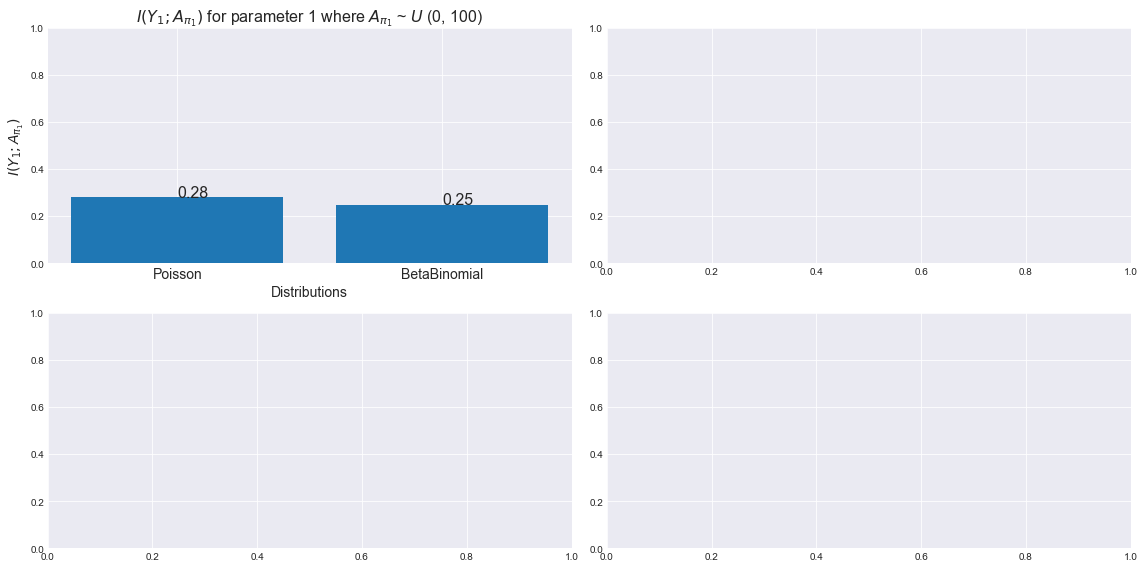

In [55]:
results.plot_mutual_information()